# LIBS

In [114]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import spacy
import copy
import scipy
import csv
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from operator import itemgetter
from collections import Counter
nlp = spacy.load("en")

# IMPORT DATA FILES

In [124]:
#add data files location/workingdirectory here

def init_data(location=None):
    counter=0
    data=list()#################################################### list to store strings of txt file
    if location==None:
        location = os.getcwd()##################################### get current working directory location here    
    for file in os.listdir(location):
        try:
            if file.endswith(".txt"):
                counter+=1
                with open(file,"r",encoding="utf-8") as f:
                    print("Counter {0} : {1}".format(counter,file))
                    data.append(f.read())
        except Exception as e:
            raise "No files found"
    return data,counter

# METHODS

In [125]:
def cosine(a,b):
    X_set=set(a)
    Y_set=set(b)
    l1 =[];l2 =[]
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0
    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine

#  

def Next_Word(data=None,test=None):
    if data==None or not data or test==None:
        print("No data or sentence")
    else:
        try:
            test_text=test
            test=nlp(test_text)
            test_1=[t.text.lower() for t in test if t.pos_ not in ['PRON','ADV'] and re.match(r'[a-zA-Z]',t.text)]
            test_l2=[list(ngrams(test_1,2))[-1]]
            #_2gram=list()
            _3gram=list()
            for i in data:
                #out=nlp(i)
                #exclude=['']
                #l1=[i.text.lower() for i in out if i.pos_ not in ['PRON','ADV'] and re.match(r'[a-zA-Z]',i.text)]
                #_1gram=l1.copy()
                #_2gram.extend(list(ngrams(l1,2)))
                with open('Hash_Table.pickle', 'rb') as f:
                    load_hash_table = pickle.load(f)
                _3gram.extend(list(ngrams(l1,3)))
                sim_mat=[[0.0 for i in range(len(test_l2))] for i in range(len(_3gram))]
                for i in range(len(_3gram)):
                    for j in range(len(test_l2)):
                        flag=0
                        for k in range(len(_3gram[i])-1):
                            if _3gram[i][k]!=test_l2[j][k]:
                                flag=1
                        if flag!=1:
                            cos=cosine(_3gram[i],test_l2[j])
                            sim_mat[i][j]=cos
            dic1={}
            dic2={}
            with open('Hash_Table.pickle', 'rb') as f:
                load_hash_table = pickle.load(f)
            for i in range(len(_3gram)):
                for j in range(len(test_l2)):
                    if sim_mat[i][j]!=0.0:
                        dic1.update({(_3gram[i],test_l2[j]):sim_mat[i][j]})
            print("Next Word"+"\t\t\t\t\t"+"Probability")
            for i in dic1.keys():
                dic2.update({i[0][-1]:Counter(_3gram)[i[0]]*dic1[i]/len(_3gram)})
            for i in Counter(dic2).most_common(3):
                print("{0}\t\t\t\t\t{1}".format(i[0],i[1]))
            #for i in dic1.keys():
                #print("{0}\t\t\t\t\t{1}".format(i[0][-1],Counter(_3gram)[i[0]]*dic1[i]/len(_3gram)))
        except Exception as e:
            raise e

In [138]:
def Next_Word(test=None):
    if data==None or not data or test==None:
        print("No data or sentence")
    else:
        try:
            test_text=test
            test=nlp(test_text)
            test_1=[t.text.lower() for t in test if t.pos_ not in ['PRON','ADV'] and re.match(r'[a-zA-Z]',t.text)]
            test_l2=[list(ngrams(test_1,2))[-1]]
            _3gram=list()
            with open('Hash_Table.pickle', 'rb') as f:
                load_hash_table = pickle.load(f)
            _3gram=[i for i in load_hash_table.keys()]
            sim_mat=[[0.0 for i in range(len(test_l2))] for i in range(len(_3gram))]
            for i in range(len(_3gram)):
                for j in range(len(test_l2)):
                    flag=0
                    for k in range(len(_3gram[i])-1):
                        if _3gram[i][k]!=test_l2[j][k]:
                            flag=1
                    if flag!=1:
                        cos=cosine(_3gram[i],test_l2[j])
                        sim_mat[i][j]=cos
            dic1={}
            dic2={}
            with open('Hash_Table.pickle', 'rb') as f:
                load_hash_table = pickle.load(f)
            for i in range(len(_3gram)):
                for j in range(len(test_l2)):
                    if sim_mat[i][j]!=0.0:
                        dic1.update({(_3gram[i],test_l2[j]):sim_mat[i][j]})
            print("Next Word"+"\t\t\t\t\t"+"Probability")
            for i in dic1.keys():
                dic2.update({i[0][-1]:load_hash_table[i[0]]*dic1[i]/len(_3gram)})
            for i in Counter(dic2).most_common(3):
                print("{0}\t\t\t\t\t{1}".format(i[0],i[1]))
            wc = WordCloud(background_color="white",width=2000,height=2000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dic2)
            plt.imshow(wc)
        except Exception as e:
            raise e

#  

In [150]:
########################### RUN ONCE ONLY TO UPDATE TABLE IF NEW FILES ADDED TO CORPUS #########################################
def build_hash_table(data=None,counter=None):
    if data==None or (not data):
        print("No data to build table")
    else:
        try:
            c=1
            grams_hash = {}
            for i in data:
                print("Reading file {0} of {1}".format(c,counter))
                out=nlp(i)
                exclude=['']
                l1=[i.text.lower() for i in out if i.pos_ not in ['PRON','ADV'] and re.match(r'[a-zA-Z]',i.text)]
                three_grams_list=list(ngrams(l1, 3))
                for gram in three_grams_list:
                    if gram not in grams_hash.keys():
                        grams_hash.update({gram:1})
                    else:
                        gram_occurrences = grams_hash[gram]
                        grams_hash.update({gram:gram_occurrences+1})
                c+=1
            #sorted_grams_hash=sorted(grams_hash.items(), key=itemgetter(1),reverse=True)
            with open('Hash_Table.pickle', 'wb') as hashes:
                pickle.dump(grams_hash, hashes, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            raise e
        

In [128]:
print(counter)

0


# FOR TESTING ONLY

# METHODS DEFINED
#### -> init\_data(foo)  : "foo" type:string, location of working directory; returns list of strings
#### -> build\_hash\_table(foo) : "foo" type:list of corpus docs strings; writes key:value\::token:count to file
#### -> Next\_Word(foo) : "foo" type:incomplete string to test; returns probability of next word 

$$TEST$$

In [129]:
data=init_data();
counter=data[1]
data=data[0]

Counter 1 : 11-0.txt
Counter 2 : 1342-0.txt
Counter 3 : 1661-0.txt
Counter 4 : 7058-0.txt
Counter 5 : Abraham Lincoln___Lincoln's Gettysburg Address, given November 19, 1863 - Copy.txt
Counter 6 : Agatha Christie___The Secret Adversary.txt
Counter 7 : Aldous Huxley___The Defeat of Youth and Other Poems.txt
Counter 8 : Alexander Pope___The Poetical Works of Alexander Pope, Volume 2.txt
Counter 9 : Alfred Russel Wallace___The Malay Archipelago, Volume 2.txt
Counter 10 : Ambrose Bierce___Can Such Things Be_.txt
Counter 11 : Andrew Lang___Tales of Troy and Greece - Copy.txt
Counter 12 : Andrew Lang___The Lilac Fairy Book - Copy.txt
Counter 13 : Andrew Lang___The Yellow Fairy Book - Copy.txt
Counter 14 : Anthony Trollope___An Eye for an Eye - Copy.txt
Counter 15 : Henry James___Madame de Mauves - Copy.txt
Counter 16 : Henry James___The Bostonians, Volume 2 - Copy.txt
Counter 17 : pg12553.txt
Counter 18 : pg2964.txt
Counter 19 : pg38054.txt
Counter 20 : Walter de la Mare___The Listeners and 

In [130]:
data;

In [132]:
build_hash_table(data,counter)

Reading file 1 of 29


Next Word					Probability
to					4.348204806206485e-06
and					3.1058605758617747e-06
as					3.1058605758617747e-06


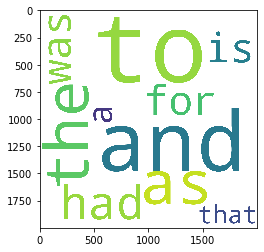

In [148]:
Next_Word("To be or not")

Next Word					Probability
be					0.00011553801342205804
have					2.1741024031032424e-05
say					1.1802270188274745e-05


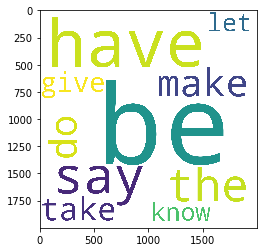

In [145]:
Next_Word("To be or not to")

Next Word					Probability
a					0.00014970247975653754
the					0.00010808394803998978
in					5.714783459585666e-05


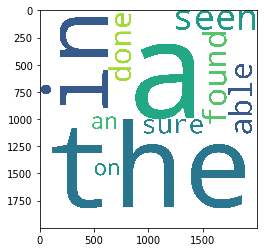

In [149]:
Next_Word("To be or not to be")